In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def get_cage_fc(row):
    try:
        hg19_exp = float(row.stem_exp_hg19)+1
    except:
        hg19_exp = 1
    try:
        mm9_exp = float(row.stem_exp_mm9)+1
    except:
        mm9_exp = 1
    cage_fc = np.log2(mm9_exp/hg19_exp)
    return cage_fc

In [6]:
def cage_status_det(row):
    if row.abs_cage_fc >= 1:
        if row.cage_fc > 0:
            return "higher in mouse"
        else:
            return "higher in human"
    else:
        return "not sig"

## variables

In [7]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [8]:
data = pd.read_table(data_f, sep="\t")
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


## 2. filter data

In [9]:
len(data)

2952

In [10]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2916

In [11]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1628

In [12]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1617

In [13]:
# data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
# len(data_filt_tile1)

In [14]:
# data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
# len(data_filt_tile1_sp)

In [15]:
# data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
# len(data_filt_tile2)

In [16]:
# data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
# len(data_filt_tile2_sp)

## 3. counts of native effects in general (across all biotypes)

In [17]:
native_order = ["no native effect", "significant native effect"]
native_pal = {"no native effect": "gray", "significant native effect": "black"}

det_order = ["native effect\n(higher in human)", "native effect\n(higher in mouse)"]
complete_pal = {"native effect\n(higher in human)": sns.color_palette("Set2")[1],
                "native effect\n(higher in mouse)": sns.color_palette("Set2")[0]}
det_pal = {"native effect\n(higher in human)": sns.color_palette("Set2")[1],
           "native effect\n(higher in mouse)": sns.color_palette("Set2")[0]}

In [18]:
# dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
# titles = ["both tiles", "tile1 only", "tile2 only"]
# labels = ["both_tiles", "tile1_only", "tile2_only"]

In [19]:
df = data_filt_sp

In [20]:
# for df, title, label in zip(dfs, titles, labels):
    
#     fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

#     sns.countplot(data=df, x="native_status", palette=native_pal, order=native_order, linewidth=2, 
#                   edgecolor=native_pal.values(), ax=ax)
#     ax.set_xticklabels(["no native effect", "native effect"], va="top", ha="right", rotation=50)
#     ax.set_xlabel("")
#     ax.set_title(title)
    
#     tot = 0
#     for i, l in enumerate(native_order):
#         n = len(df[df["native_status"] == l])
#         tot += n
#         ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
#     print("percent native sig: %s" % (n/tot))

#     plt.show()
#     fig.savefig("count_native_status.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

percent native sig: 0.2683982683982684


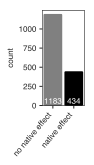

In [21]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=df, x="native_status", palette=native_pal, order=native_order, linewidth=2, 
              edgecolor=native_pal.values(), ax=ax)
ax.set_xticklabels(["no native effect", "native effect"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

tot = 0
for i, l in enumerate(native_order):
    n = len(df[df["native_status"] == l])
    tot += n
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
print("percent native sig: %s" % (n/tot))

plt.show()
fig.savefig("count_native_status.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [22]:
# for df, title, label in zip(dfs, titles, labels):
    
#     fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

#     sns.countplot(data=df, x="native_status_det", palette=complete_pal, order=det_order, ax=ax, linewidth=2,
#                   edgecolor=det_pal.values())

#     for i, l in enumerate(det_order):
#         n = len(df[df["native_status_det"] == l])
#         ax.annotate(str(n), xy=(i, 15), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)

#     ax.set_xticklabels(["higher in human", "higher in mouse"], va="top", ha="right", rotation=50)
#     ax.set_xlabel("")
#     ax.set_ylabel("count")
#     ax.set_title(title)
#     fig.savefig("count_native_status_detail.%s.pdf" % label, dpi="figure", bbox_inches="tight")

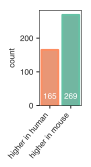

In [23]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=df, x="native_status_det", palette=complete_pal, order=det_order, ax=ax, linewidth=2,
              edgecolor=det_pal.values())

for i, l in enumerate(det_order):
    n = len(df[df["native_status_det"] == l])
    ax.annotate(str(n), xy=(i, 15), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

ax.set_xticklabels(["higher in human", "higher in mouse"], va="top", ha="right", rotation=50)
ax.set_xlabel("")
ax.set_ylabel("count")
fig.savefig("count_native_status_detail.pdf", dpi="figure", bbox_inches="tight")

## 4. count of native status when looking only at CAGE

In [24]:
det_order = ["higher in human", "higher in mouse"]
pal = {"higher in human": sns.color_palette("Set2")[1], "higher in mouse": sns.color_palette("Set2")[0]}

In [25]:
# for df, title, label in zip(dfs, titles, labels):
#     df["cage_fc"] = df.apply(get_cage_fc, axis=1)
#     df["abs_cage_fc"] = np.abs(df["cage_fc"])
#     df["cage_status_det"] = df.apply(cage_status_det, axis=1)
#     sub = df[df["cage_status_det"] != "not sig"]
    
#     fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

#     sns.countplot(data=sub, x="cage_status_det", palette=pal, order=det_order, linewidth=2,
#                   edgecolor=pal.values(), ax=ax)

#     for i, l in enumerate(det_order):
#         n = len(df[df["cage_status_det"] == l])
#         ax.annotate(str(n), xy=(i, 15), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)

#     ax.set_xticklabels(["higher in human", "higher in mouse"], va="top", ha="right", rotation=50)
#     ax.set_xlabel("")
#     ax.set_ylabel("count")
#     ax.set_title(title)
#     fig.savefig("count_cage_status_detail.%s.pdf" % label, dpi="figure", bbox_inches="tight")

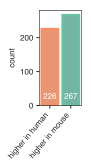

In [26]:
df["cage_fc"] = df.apply(get_cage_fc, axis=1)
df["abs_cage_fc"] = np.abs(df["cage_fc"])
df["cage_status_det"] = df.apply(cage_status_det, axis=1)
sub = df[df["cage_status_det"] != "not sig"]

fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=sub, x="cage_status_det", palette=pal, order=det_order, linewidth=2,
              edgecolor=pal.values(), ax=ax)

for i, l in enumerate(det_order):
    n = len(df[df["cage_status_det"] == l])
    ax.annotate(str(n), xy=(i, 15), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

ax.set_xticklabels(["higher in human", "higher in mouse"], va="top", ha="right", rotation=50)
ax.set_xlabel("")
ax.set_ylabel("count")
fig.savefig("count_cage_status_detail.pdf", dpi="figure", bbox_inches="tight")

## 5. effect sizes across biotypes

In [27]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]

In [28]:
# for df, title, label in zip(dfs, titles, labels):
#     df["abs_logFC_native"] = np.abs(df["logFC_native"])

#     fig = plt.figure(figsize=(2.5, 2))
#     ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_native", 
#                      flierprops = dict(marker='o', markersize=5), 
#                      order=min_switch_order, color=sns.color_palette("Set2")[2])
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("native effect size")
#     ax.set_title(title)

#     for i, l in enumerate(min_switch_order):
#         sub = df[df["biotype_switch_minimal"] == l]
#         n = len(sub)
#         print("%s median eff size: %s" % (l, sub["abs_logFC_native"].median()))
#         color = sns.color_palette("Set2")[2]
#         ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=color, size=fontsize)

#     ax.set_ylim((-0.8, 4.5))
#     ax.axvline(x=2.5, linestyle="dashed", color="black")

#     plt.show()
#     fig.savefig("native_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

In [29]:
def turnover_status(row):
    if "CAGE turnover" in row["biotype_switch_minimal"]:
        return "CAGE turnover"
    else:
        return "none"
    
def turnover_biotype(row):
    if "CAGE turnover" in row["biotype_switch_minimal"]:
        return row["biotype_switch_minimal"].split(" - ")[1]
    else:
        return row["biotype_switch_minimal"]

In [30]:
turnover_order = ["eRNA", "lncRNA", "mRNA"]
turnover_pal = {"CAGE turnover": "gray", "none": sns.color_palette("Set2")[2]}
hue_order = ["CAGE turnover", "none"]

In [31]:
# for df, title, label in zip(dfs, titles, labels):
#     df["abs_logFC_native"] = np.abs(df["logFC_native"])
#     df["turnover_status"] = df.apply(turnover_status, axis=1)
#     df["turnover_biotype"] = df.apply(turnover_biotype, axis=1)
    
#     fig = plt.figure(figsize=(2.5, 2))
#     ax = sns.boxplot(data=df, x="turnover_biotype", y="abs_logFC_native", hue="turnover_status",
#                      flierprops = dict(marker='o', markersize=5), 
#                      order=turnover_order, hue_order=hue_order, palette=turnover_pal)
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(turnover_order, rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("native effect size")
#     ax.set_title(title)

#     for i, l in enumerate(turnover_order):
#         sub = df[df["turnover_biotype"] == l]
#         dist1 = np.asarray(sub[sub["turnover_status"] == "CAGE turnover"]["abs_logFC_native"])
#         dist2 = np.asarray(sub[sub["turnover_status"] == "none"]["abs_logFC_native"])
        
#         dist1 = dist1[~np.isnan(dist1)]
#         dist2 = dist2[~np.isnan(dist2)]
        
#         u, pval = stats.mannwhitneyu(dist1, dist2, alternative="greater", use_continuity=False)
        
#         if pval >= 0.05:
#             annotate_pval(ax, i-0.1, i+0.1, 2.4, 0, 2.4, pval, fontsize)
#         else:
#             annotate_pval(ax, i-0.1, i+0.1, 2.4, 0, 2.2, pval, fontsize)
            
#         ax.annotate(str(len(dist1)), xy=(i-0.25, -0.7), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="gray", size=fontsize)
#         ax.annotate(str(len(dist2)), xy=(i+0.25, -0.7), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=sns.color_palette("Set2")[2], size=fontsize)

#     ax.set_ylim((-0.8, 5))
#     plt.legend(loc=2, bbox_to_anchor=(1.1, 1))
#     plt.show()
# #     fig.savefig("native_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

## 6. number sig across biotypes

In [32]:
# for df, title, label in zip(dfs, titles, labels):

#     tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     sig = df[df["native_status"] != "no native effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
#     clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
#                      order=min_switch_order, color=sns.color_palette("Set2")[2])

#     ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("% of seq. pairs with\nnative effects")
#     ax.set_title(title)
#     ax.axvline(x=2.5, linestyle="dashed", color="black")
    
#     for i, l in enumerate(min_switch_order):
#         sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
#         print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
#         n = sub["hg19_id_x"].iloc[0]
#         ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
    
#     plt.show()
#     fig.savefig("perc_sig_native_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA perc sig: 44.9275362319
CAGE turnover - lncRNA perc sig: 31.25
CAGE turnover - mRNA perc sig: 48.3870967742
eRNA perc sig: 29.797979798
lncRNA perc sig: 24.4897959184
mRNA perc sig: 22.9674796748


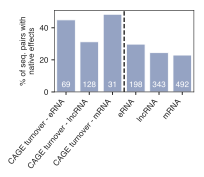

In [33]:
tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
sig = df[df["native_status"] != "no native effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100

fig = plt.figure(figsize=(2.5, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                 order=min_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of seq. pairs with\nnative effects")
ax.axvline(x=2.5, linestyle="dashed", color="black")

for i, l in enumerate(min_switch_order):
    sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
    print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
    n = sub["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

plt.show()
fig.savefig("perc_sig_native_minimal_biotype_switch.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 7. direc v. comp in native status

In [34]:
# for df, title, label in zip(dfs, titles, labels):
#     res = {}
#     native = df[df["native_status"] != "no native effect"]
#     no_native = df[df["native_status"] == "no native effect"]
    
#     native_cis_trans = native[(native["cis_status_one"] == "significant cis effect") & 
#                               (native["trans_status_one"] == "significant trans effect")]
#     no_native_cis_trans = no_native[(no_native["cis_status_one"] == "significant cis effect") & 
#                                     (no_native["trans_status_one"] == "significant trans effect")]
    
#     native_direc = native_cis_trans[((native_cis_trans["cis_status_det_one"].str.contains("higher in human") & 
#                                       native_cis_trans["trans_status_det_one"].str.contains("higher in human")) |
#                                      (native_cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
#                                       native_cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
#     no_native_direc = no_native_cis_trans[((no_native_cis_trans["cis_status_det_one"].str.contains("higher in human") & 
#                                       no_native_cis_trans["trans_status_det_one"].str.contains("higher in human")) |
#                                      (no_native_cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
#                                       no_native_cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
    
#     res["perc_native_direc"] = (len(native_direc)/len(native_cis_trans))*100
#     res["perc_no_native_direc"] = (len(no_native_direc)/len(no_native_cis_trans)*100)
#     res = pd.DataFrame.from_dict(res, orient="index").reset_index()
            
#     order = ["perc_no_native_direc", "perc_native_direc"]
#     pal = {"perc_no_native_direc": "gray", "perc_native_direc": sns.color_palette("Set2")[2]}
#     fig, ax = plt.subplots(figsize=(1, 2), nrows=1, ncols=1)
    
#     sns.barplot(data=res, x="index", y=0, order=order, palette=pal, ax=ax)
#     ax.set_xticklabels(["no native effects", "native effects"], rotation=50, ha="right", va="top")
#     ax.set_xlabel("")
#     ax.set_ylabel("% of pairs with cis & trans effects\nshowing directional effects")
#     plt.show()
#     fig.savefig("native_cis_trans_breakup.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()